In [152]:
import json
import pprint
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections.abc import Iterable
import cv2
import torch
import torchvision.transforms as T

from model import EAST
from detect import detect

result_subtitles = (
    "Left side distance",
    "Right side distance",
    "Upper side distance",
    "Down side distance",
    "Angle"
)

exp_names = [
    'Original',
    'Projective Transform',
    'Bbox Expansion',
    'Bbox Shrinking',
    'Bbox Shaking'
]
image_root_dir = '/opt/ml/input/data/'
train_ufo_paths = [
    '/opt/ml/input/data/ICDAR17_Korean_UFO.json',
    '/opt/ml/input/data/ICDAR17_Korean_UFO_warped.json',
    '/opt/ml/input/data/ICDAR17_Korean_UFO_expanded.json',
    '/opt/ml/input/data/ICDAR17_Korean_UFO_shrunk.json',
    '/opt/ml/input/data/ICDAR17_Korean_UFO_shaked.json',
]
model_param_paths = [
    '/opt/ml/code/trained_models/latest.pth',
    '/opt/ml/code/trained_models/warped_latest.pth',
    '/opt/ml/code/trained_models/expanded_latest.pth',
    '/opt/ml/code/trained_models/shrunk_latest.pth',
    '/opt/ml/code/trained_models/shaked_latest.pth',
]
    
baseline_param_path = '/opt/ml/code/pths/vgg16_bn-6c64b313.pth'

gts = [
    json.load(open(path)) for path in train_ufo_paths
]

image_names_origin = [name for name in gts[0]['images']]
image_names_warped = [name for name in gts[1]['images']]

to_tensor = T.ToTensor()

In [146]:
models = [EAST(pretrained=False) for _ in range(len(model_param_paths))]

for model, param_path in zip(models, model_param_paths):
    model.load_state_dict(torch.load(param_path))
    model.eval()

In [147]:
orgnal_image_name_list = [
    'ICDAR17_Korean/img_4650.jpg',
    'ICDAR17_Korean/img_1091.jpg',
    'ICDAR17_Korean/img_4503.jpg',
    'ICDAR17_Korean/img_1029.jpg',
    'ICDAR17_Korean/img_1105.jpg'
]
warped_image_name_list = [
    'ICDAR17_Korean_warped/img_4650.jpg',
    'ICDAR17_Korean_warped/img_1091.jpg',
    'ICDAR17_Korean_warped/img_4503.jpg',
    'ICDAR17_Korean_warped/img_1029.jpg',
    'ICDAR17_Korean_warped/img_1105.jpg'
]

2448 1836
1216 896


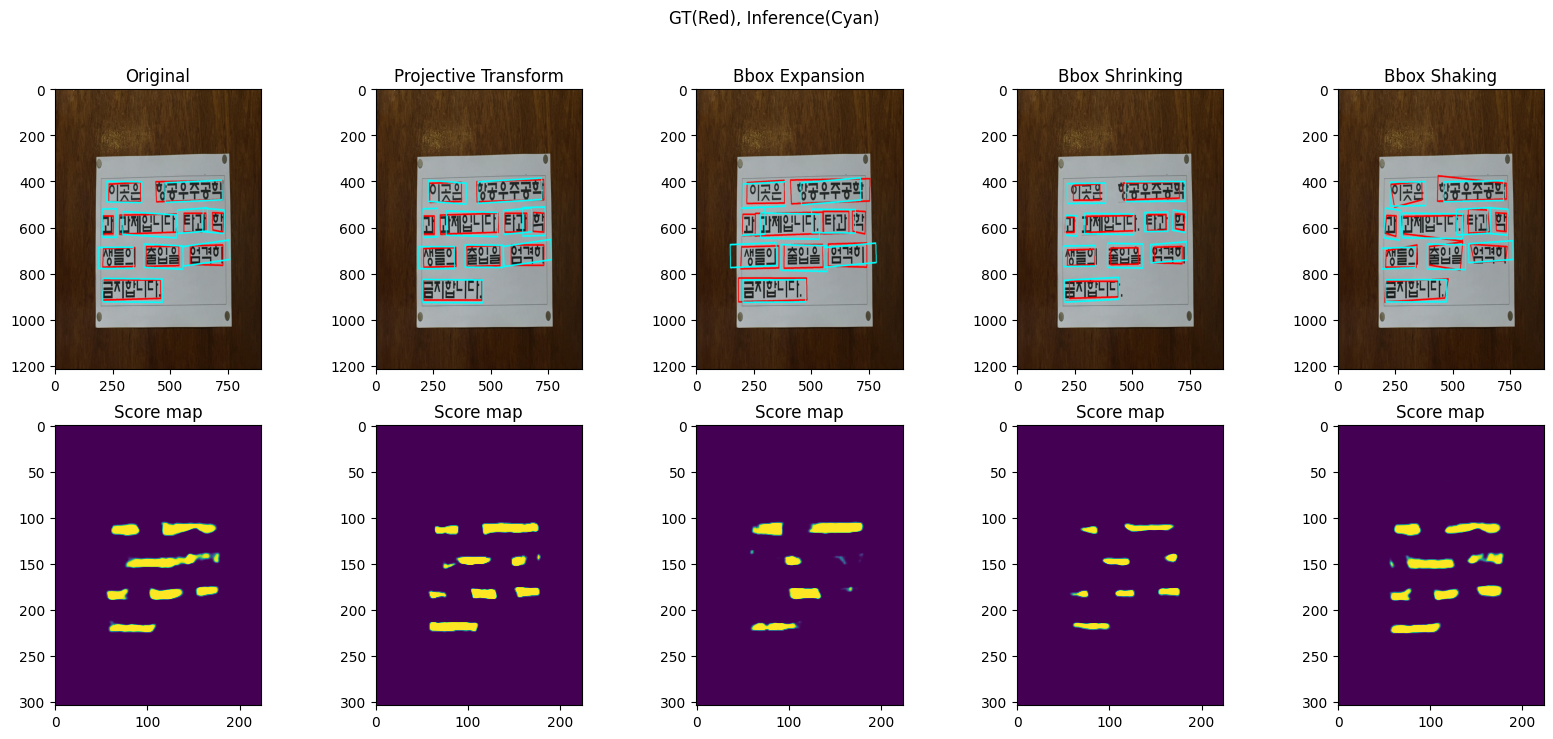

In [165]:
# index = np.random.randint(0, len(image_names_origin))
# image_names_lists = []
# image_names_lists.append(image_names_origin[index])
# image_names_lists.append(image_names_warped[index])
# image_names_lists.append(image_names_origin[index])
# image_names_lists.append(image_names_origin[index])
# image_names_lists.append(image_names_origin[index])

n = 4
image_names_lists = []
image_names_lists.append(orgnal_image_name_list[n])
image_names_lists.append(warped_image_name_list[n])
image_names_lists.append(orgnal_image_name_list[n])
image_names_lists.append(orgnal_image_name_list[n])
image_names_lists.append(orgnal_image_name_list[n])

width = gts[0]['images'][image_names_lists[0]]['img_w']
height = gts[0]['images'][image_names_lists[0]]['img_h']

images = []
image_o = cv2.imread(os.path.join(image_root_dir, image_names_lists[0]))
image_o = cv2.cvtColor(image_o, cv2.COLOR_BGR2RGB)
images.append(image_o.copy())

image_w = cv2.imread(os.path.join(image_root_dir, image_names_lists[1]))
image_w = cv2.cvtColor(image_w, cv2.COLOR_BGR2RGB)
images.append(image_w.copy())

images.append(image_o.copy())
images.append(image_o.copy())
images.append(image_o.copy())

print(width, height)
width = (width // 64) * 32
height = (height // 64) * 32
print(width, height)
resize = T.Resize((width,height))

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("GT(Red), Inference(Cyan)")

# For every model
for i in range(len(images)):
    bboxes_gt = [
        gts[i]['images'][image_names_lists[i]]['words'][word]['points']
        for word in gts[i]['images'][image_names_lists[i]]['words']
    ]
    for bbox in bboxes_gt:
        pts = np.array(bbox, np.int32).reshape((-1, 1, 2))
        images[i] = cv2.polylines(
            images[i],
            [pts],
            isClosed=True,
            color=(255, 0, 0),
            thickness=10
        )
    

    output = detect(model, np.expand_dims(images[i], axis=0), width)

    # print(i, output[0])
    for bbox in output[0]:
        pts = np.array(bbox, np.int32).reshape((-1, 1, 2))
        images[i] = cv2.polylines(
            images[i],
            [pts],
            isClosed=True,
            color=(0, 255, 255),
            thickness=10
        )

    
    images[i] = resize(to_tensor(images[i])).unsqueeze(dim=0)
    score, geo = models[i](images[i])

    images[i] = images[i].squeeze(0).permute(1, 2, 0)
    ax[0, i].imshow(images[i])
    ax[0, i].set_title(f"{exp_names[i]}")

    score = score.squeeze().detach().numpy()
    ax[1, i].imshow(score)
    ax[1, i].set_title(f"Score map")

fig.show()

ICDAR17_Korean/img_4246.jpg
2268 2268
2240 2240
torch.Size([1, 1, 560, 560])
torch.Size([1, 5, 560, 560])


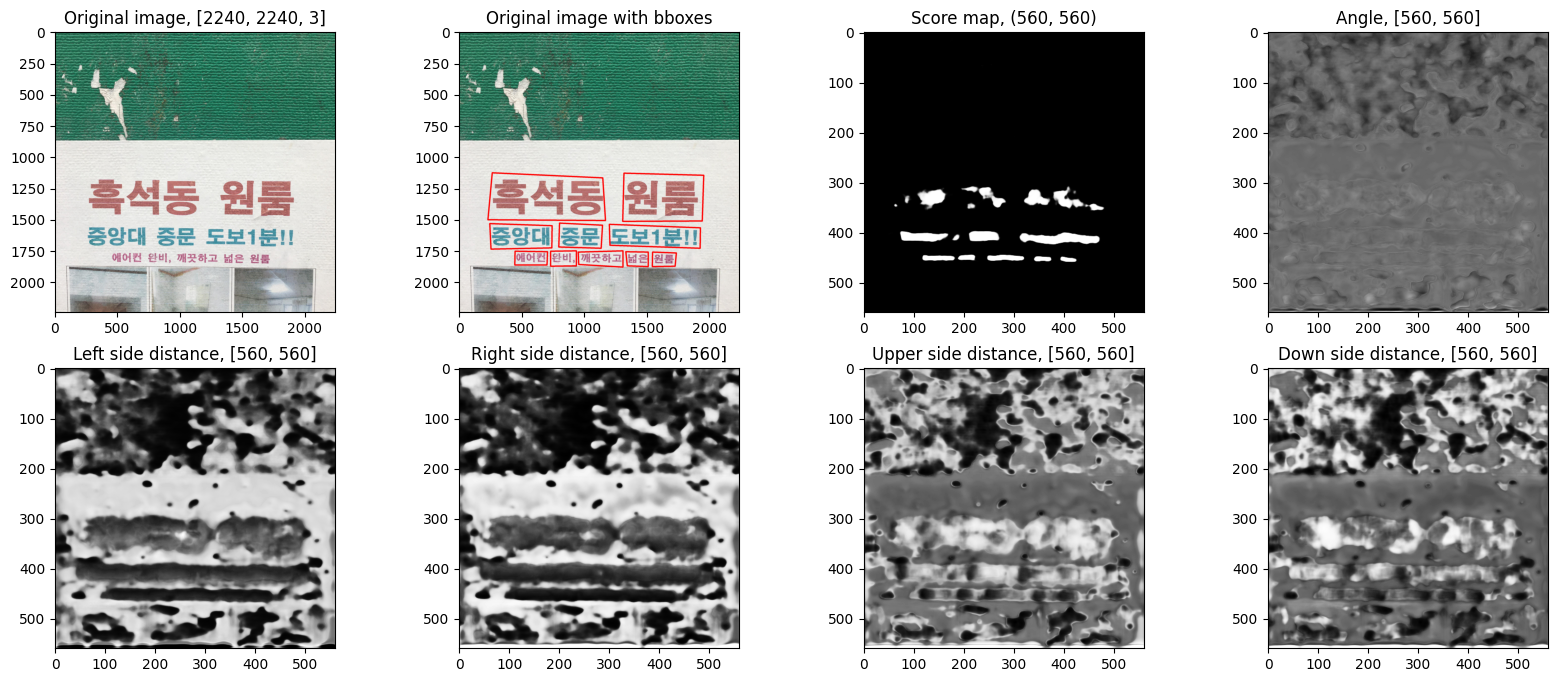

In [112]:
index = np.random.randint(0, len(image_names))
image_name = image_names[index]
# image_name = 'ICDAR17_Korean/img_1091.jpg'
print(image_name)

# image = cv2.imread(os.path.join(image_root_dir, image_name))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(image)
# plt.show()

width = gt['images'][image_name]['img_w']
height = gt['images'][image_name]['img_h']

image = cv2.imread(os.path.join(image_root_dir, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(width, height)
width = (width // 32) * 32
height = (height // 32) * 32
print(width, height)
resize = T.Resize((width,height))

bboxes = [
    gt['images'][image_name]['words'][word]['points']
    for word in gt['images'][image_name]['words']
]
image_gt = image.copy()
for bbox in bboxes:
    pts = np.array(bbox, np.int32).reshape((-1, 1, 2))
    image_gt = cv2.polylines(
        image_gt,
        [pts],
        isClosed=True,
        color=(255, 0, 0),
        thickness=10
    )

image = resize(to_tensor(image)).unsqueeze(dim=0)
image_gt = resize(to_tensor(image_gt)).unsqueeze(dim=0)

score, geo = model(image)
print(score.size())
print(geo.size())

fig, ax = plt.subplots(2, 4, figsize=(20, 8))

image = image.squeeze(0).permute(1, 2, 0)
ax[0, 0].imshow(image)
ax[0, 0].set_title(f"Original image, {list(image.shape)}")

image_gt = image_gt.squeeze(0).permute(1, 2, 0)
ax[0, 1].imshow(image_gt)
ax[0, 1].set_title(f"Original image with bboxes")

geo = geo.squeeze(0).detach().numpy()
ax[0, 3].imshow(geo[4], cmap='gray')
ax[0, 3].set_title(f"{result_subtitles[4]}, {list(geo[4].shape)}")
for i in range(4):
    ax[1, i].imshow(geo[i], cmap='gray')
    ax[1, i].set_title(f"{result_subtitles[i]}, {list(geo[i].shape)}")

score = score.squeeze().detach().numpy()
ax[0, 2].imshow(score, cmap='gray')
ax[0, 2].set_title(f"Score map, {score.shape}")

fig.show()